# ARIMAX Models

In [106]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv(
    './PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv'
    , sep=','
)
df = df.fillna(method='ffill')
data_cols = df.columns[11:-4].to_list() + [df.columns[16]]

Plot individual series for reminder of the data.

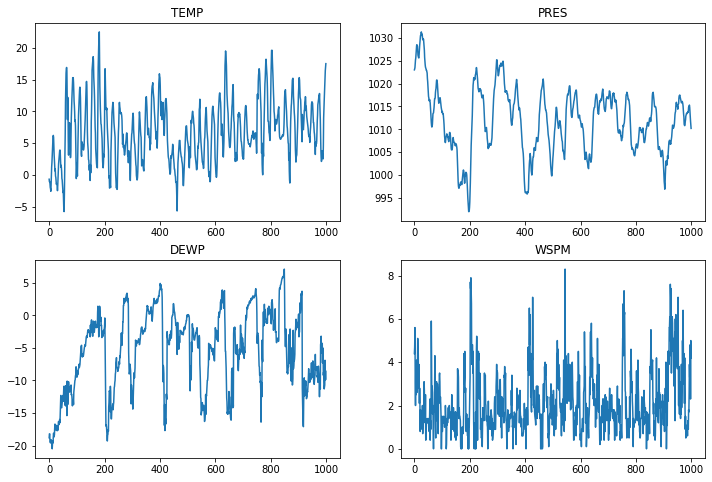

In [3]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
for idx, series in enumerate(data_cols):
    ax_ = ax[idx//2,idx%2]
    ax_.set_title(series)
    df[series].iloc[:1000].plot(ax=ax_)

Determine cross-correlations to use.

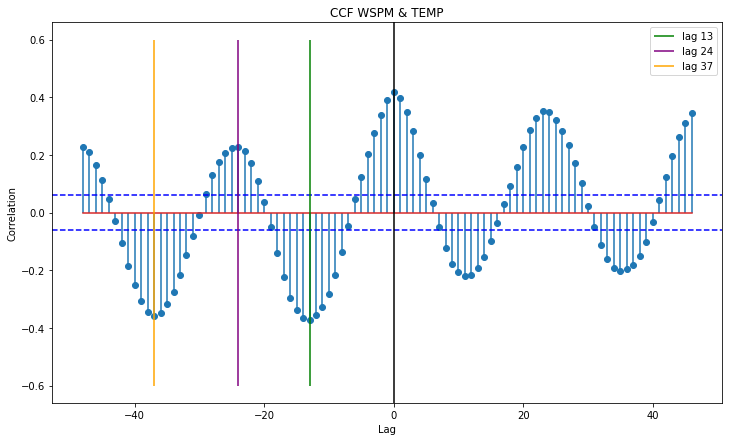

In [24]:
from scipy.signal import correlate

# code adapted from chapter 10
def plot_ccf(data_a, data_b, lag_lookback, percentile, ax, title=None):

    n = len(data_a)
    ccf = correlate(data_a - np.mean(data_a), data_b - np.mean(data_b), method='direct') / (np.std(data_a) * np.std(data_b) * n)

    _min = (len(ccf)-1)//2 - lag_lookback
    _max = (len(ccf)-1)//2 + (lag_lookback-1)

    zscore_vals={90:1.645,
                 95:1.96,
                 99:2.576}

    markers, stems, baseline = ax.stem(np.arange(-lag_lookback,(lag_lookback-1)), ccf[_min:_max], markerfmt='o', use_line_collection = True)
    z_score_95pct = zscore_vals.get(percentile)/np.sqrt(n) #1.645 for 90%, 1.96 for 95%, and 2.576 for 99%

    ax.set_title(title)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    ax.axhline(y=-z_score_95pct, color='b', ls='--')# Z-statistic for 95% CL LL
    ax.axhline(y=z_score_95pct, color='b', ls='--')# Z-statistic for 95% CL UL
    ax.axvline(x=0, color='black', ls='-')
    
size = 1000
fig, ax = plt.subplots(1,1, figsize=(12, 7))

plot_ccf(df.WSPM.iloc[:size], df.TEMP.iloc[:size], 48, 95, ax, title="CCF WSPM & TEMP")
ax.vlines(-13, -0.6, 0.6, colors='green', label='lag 13')
ax.vlines(-24, -0.6, 0.6, colors='purple', label='lag 24')
ax.vlines(-37, -0.6, 0.6, colors='orange', label='lag 37')
ax.legend()
#fig.savefig('wspm_temp_ccf.png', dpi=300)

#plot_ccf(df.WSPM.iloc[:size], df.PRES.iloc[:size], 48, 95, ax[0], title="CCF WSPM & PRES")
#plot_ccf(df.WSPM.iloc[:size], df.DEWP.iloc[:size], 48, 95, ax[2], title="CCF WSPM & DEWP")
#fig.savefig('ccf.png', dpi=300)

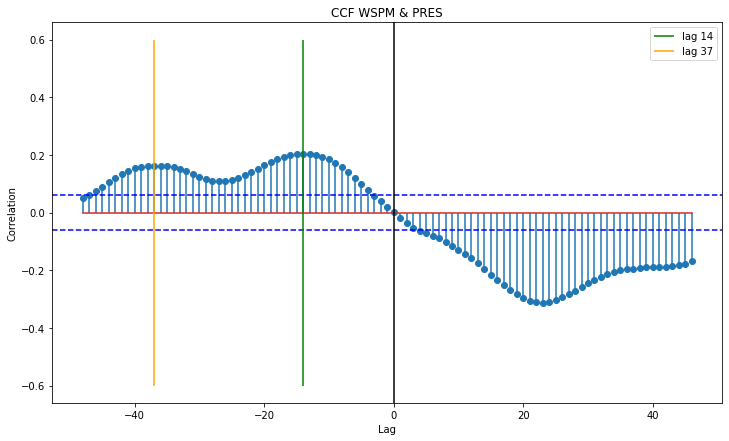

In [49]:
size = 1000
fig, ax = plt.subplots(1,1, figsize=(12, 7))

plot_ccf(df.WSPM.iloc[:size], df.PRES.iloc[:size], 48, 95, ax, title="CCF WSPM & PRES")
ax.vlines(-14, -0.6, 0.6, colors='green', label='lag 14')
ax.vlines(-37, -0.6, 0.6, colors='orange', label='lag 37')
ax.legend()
#fig.savefig('wspm_temp_ccf.png', dpi=300)

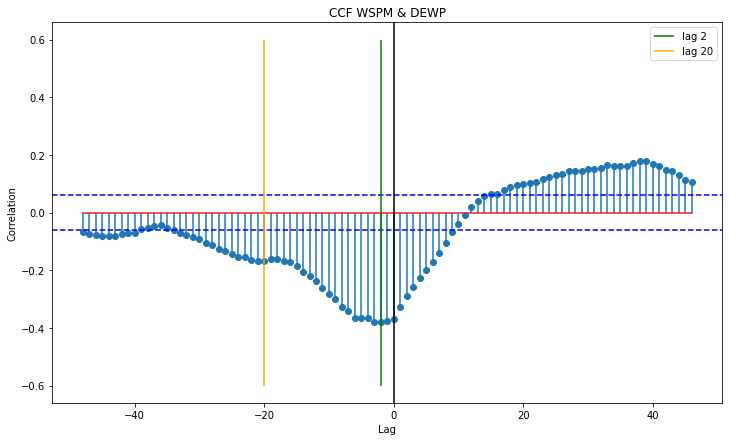

In [53]:
size = 1000
fig, ax = plt.subplots(1,1, figsize=(12, 7))

plot_ccf(df.WSPM.iloc[:size], df.DEWP.iloc[:size], 48, 95, ax, title="CCF WSPM & DEWP")
ax.vlines(-2, -0.6, 0.6, colors='green', label='lag 2')
ax.vlines(-20, -0.6, 0.6, colors='orange', label='lag 20')
ax.legend()

Preprocess the data.

In [95]:
temp_lag_13 = df.TEMP.shift(-13)
temp_lag_24 = df.TEMP.shift(-24)
temp_lag_37 = df.TEMP.shift(-37)

pres_lag_14 = df.PRES.shift(-14)
pres_lag_24 = df.PRES.shift(-37)

dewp_lag_13 = df.DEWP.shift(-2)
dewp_lag_24 = df.DEWP.shift(-20)


X = pd.DataFrame({
    "temp_lag_13": temp_lag_13[:1000],
    "temp_lag_24": temp_lag_24[:1000],
    "temp_lag_37": temp_lag_37[:1000],
    "pres_lag_14": pres_lag_14[:1000],
    "pres_lag_24": pres_lag_24[:1000],
    "dewp_lag_2": dewp_lag_13[:1000],
    "dewp_lag_20": dewp_lag_24[:1000],
})

y = df.WSPM[:1000]

Fit the model.

In [78]:
arima = pm.auto_arima(
    y, X,
    error_action='ignore',
    trace=True, 
    suppress_warnings=True,
    maxiter=5,
    seasonal=False, 
    test='adf'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2689.456, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8635.103, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2742.728, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2923.324, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2685.581, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2810.239, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2683.888, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2682.988, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2681.309, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2682.416, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2684.608, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2683.328, Time=0.27 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 3.300 seconds


In [79]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1330.654
Date:                Wed, 01 Feb 2023   AIC                           2681.309
Time:                        20:15:59   BIC                           2730.386
Sample:                             0   HQIC                          2699.962
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_lag_13    -0.0279      0.021     -1.355      0.175      -0.068       0.012
temp_lag_24     0.0560      0.014      3.887      0.000       0.028       0.084
temp_lag_37    -0.0587      0.020     -2.961    

In [86]:
# repeating this part to make this cell rerunable
X = pd.DataFrame({
    "temp_lag_13": temp_lag_13[:1000],
    "temp_lag_24": temp_lag_24[:1000],
    "temp_lag_37": temp_lag_37[:1000],
    "pres_lag_14": pres_lag_14[:1000],
    "pres_lag_24": pres_lag_24[:1000],
    "dewp_lag_2": dewp_lag_13[:1000],
    "dewp_lag_20": dewp_lag_24[:1000],
})

# initial model
arima = pm.auto_arima(
    y, X,
    error_action='ignore',
    trace=False, 
    suppress_warnings=True,
    maxiter=5,
    seasonal=False, 
    test='adf'
)

pvalues = arima.pvalues()
iterations = 0

while (pvalues > 0.05).any():
    # get the variable name with the largest p-value
    variable_with_max_pval = pvalues.idxmax()
    # drop that variable from the exogenous variables
    X = X.drop(variable_with_max_pval, axis=1)
    arima = pm.auto_arima(
        y, X,
        error_action='ignore',
        trace=False, 
        suppress_warnings=True,
        maxiter=5,
        seasonal=False, 
        test='adf'
    )
    pvalues = arima.pvalues()
    print(f"fit iteration {iterations}")
    iterations += 1

fit iteration 0
fit iteration 1
fit iteration 2


In [88]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1332.165
Date:                Wed, 01 Feb 2023   AIC                           2678.331
Time:                        20:19:51   BIC                           2712.685
Sample:                             0   HQIC                          2691.388
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temp_lag_24     0.0575      0.014      4.143      0.000       0.030       0.085
temp_lag_37    -0.0765      0.016     -4.850      0.000      -0.107      -0.046
pres_lag_24     0.0019      0.000      8.698    

Assess the model performance.

In [98]:
# create test data
X_test = pd.DataFrame({
    #"temp_lag_13": temp_lag_13[1000:200],
    "temp_lag_24": temp_lag_24[1000:1200],
    "temp_lag_37": temp_lag_37[1000:1200],
    #"pres_lag_14": pres_lag_14[1000:200],
    "pres_lag_24": pres_lag_24[1000:1200],
    "dewp_lag_2": dewp_lag_13[1000:1200],
    #"dewp_lag_20": dewp_lag_24[1000:200],
})

y_test = df.WSPM[1000:1200]

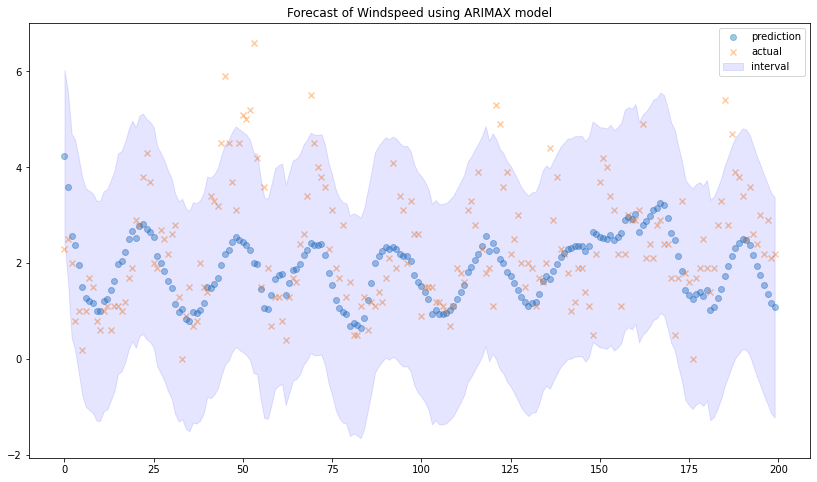

In [118]:
preds, conf_int = arima.predict(X=X_test, n_periods=X_test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.scatter(np.arange(preds.size), preds, alpha=0.4, marker='o', label='prediction')
axes.scatter(np.arange(y_test.size), y_test, alpha=0.4, marker='x', label='actual')
axes.fill_between(np.arange(y_test.size), conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b', label='interval')
axes.legend()
axes.set_title("Forecast of Windspeed using ARIMAX model");
#fig.savefig('ARIMAX_forecast.png', dpi=300);

In [116]:
mean_squared_error(y_test, preds)

1.5177747041371006

Fit a baseline univariate model

In [111]:
arima_uni = pm.auto_arima(
    y,
    error_action='ignore',
    trace=False, 
    suppress_warnings=True,
    maxiter=5,
    seasonal=False, 
    test='adf'
)

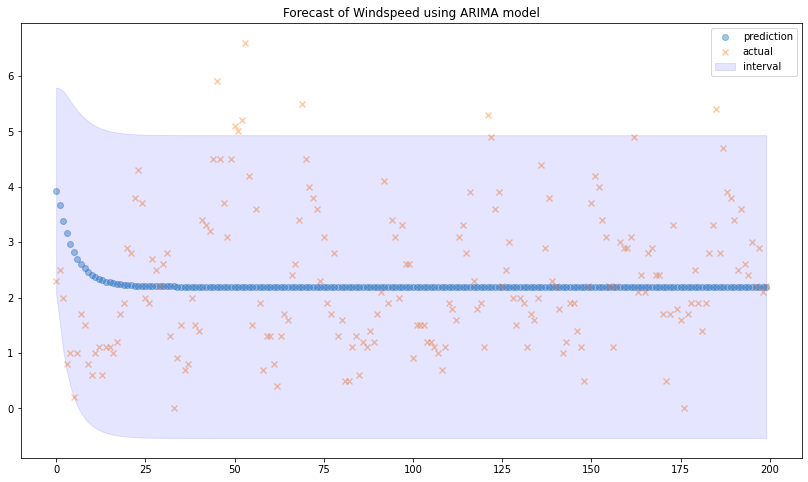

In [119]:
preds_uni, conf_int_uni = arima_uni.predict(n_periods=X_test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.scatter(np.arange(preds_uni.size), preds_uni, alpha=0.4, marker='o', label='prediction')
axes.scatter(np.arange(y_test.size), y_test, alpha=0.4, marker='x', label='actual')
axes.fill_between(np.arange(y_test.size), conf_int_uni[:, 0], conf_int_uni[:, 1], alpha=0.1, color='b', label='interval')
axes.legend()
axes.set_title("Forecast of Windspeed using ARIMA model");
#fig.savefig('ARIMA_forecast.png', dpi=300);

In [117]:
mean_squared_error(y_test, preds_uni)

1.702042530954597